In [101]:
from pathlib import Path

import pandas as pd
import regex as re
from IPython.core.display_functions import display

In [102]:
data_dir = "./exp-local/data"


def import_data(dir):
    all_files = Path(dir).glob('data*.txt')
    all_data = [pd.read_fwf(path, skiprows=[1], index_col=None) for path in all_files]
    return pd.concat(all_data, axis=0, ignore_index=True)


data = import_data(data_dir)
data

,JobID,JobName,Cluster,Unnamed: 3,NodeList,State,Start,End,ConsumedEnergy,AveRSS,...,UID,User,WCKey,WCKeyID,WorkDir,Submit,Unnamed: 112,Unnamed: 113,SubmitLine,Unnamed: 114
0,49263,daa-local-nc4_gl5-28.cfg,gl2_gl4,NaN,gl5,FAILED,2024-01-19T12:19:37,2024-01-19T12:19:37,NaN,NaN,...,1009.0,greenBeans,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-19T12:09:30,sbatch --job-name=daa-local-nc4_gl5-28.cfg -w ...,&& haddock3 'daa-local-nc4_gl5-28.cfg',> run.daa-local-nc4_gl5-28.cfg.info/haddock.ou...,NaN
1,49263.batch,batch,gl2_gl4,NaN,gl5,FAILED,2024-01-19T12:19:37,2024-01-19T12:19:37,10,876K,...,NaN,NaN,NaN,NaN,NaN,2024-01-19T12:19:37,NaN,NaN,NaN,NaN
2,49266,daa-local-nc4_gl5-24.cfg,gl2_gl4,NaN,gl5,FAILED,2024-01-19T12:24:44,2024-01-19T12:24:44,NaN,NaN,...,1009.0,greenBeans,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-19T12:09:30,sbatch --job-name=daa-local-nc4_gl5-24.cfg -w ...,&& haddock3 'daa-local-nc4_gl5-24.cfg',> run.daa-local-nc4_gl5-24.cfg.info/haddock.ou...,NaN
3,49266.batch,batch,gl2_gl4,NaN,gl5,FAILED,2024-01-19T12:24:44,2024-01-19T12:24:44,13,880K,...,NaN,NaN,NaN,NaN,NaN,2024-01-19T12:24:44,NaN,NaN,NaN,NaN
4,49269,dpp-local-nc4_gl5-22.cfg,gl2_gl4,NaN,gl5,FAILED,2024-01-19T12:29:50,2024-01-19T12:29:51,NaN,NaN,...,1009.0,greenBeans,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-19T12:09:30,sbatch --job-name=dpp-local-nc4_gl5-22.cfg -w ...,&& haddock3 'dpp-local-nc4_gl5-22.cfg',> run.dpp-local-nc4_gl5-22.cfg.info/haddock.ou...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,49182,daa-local-nc2_gl6-35.cfg,gl2_gl4,None,assigned,CANCELLED+,None,2024-01-17T15:42:49,0,NaN,...,1009.0,greenBeans,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:13:00,sbatch --job-name=daa-local-nc2_gl6-35.cfg -w,gl6 -n 2 --dependency=afterany:49181 --wrap=(p...,> run.daa-local-nc2_gl6-35.cfg.info/haddock.ou...,"-e power/energy-pkg/,power/energy-ram/ haddock..."
228,49185,daa-local-nc16_gl6-32.cfg,gl2_gl4,None,assigned,PENDING,Unknown,Unknown,0,NaN,...,1009.0,greenBeans,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:13:00,sbatch --job-name=daa-local-nc16_gl6-32.cfg -w...,-n 16 --dependency=afterany:49184 --wrap=(perf...,run.daa-local-nc16_gl6-32.cfg.info/haddock.out...,"power/energy-pkg/,power/energy-ram/ haddock3 '..."
229,49188,daa-local-nc4_gl6-37.cfg,gl2_gl4,None,assigned,PENDING,Unknown,Unknown,0,NaN,...,1009.0,greenBeans,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:13:00,sbatch --job-name=daa-local-nc4_gl6-37.cfg -w,gl6 -n 4 --dependency=afterany:49187 --wrap=(p...,> run.daa-local-nc4_gl6-37.cfg.info/haddock.ou...,"-e power/energy-pkg/,power/energy-ram/ haddock..."
230,49191,daa-local-nc2_gl6-37.cfg,gl2_gl4,None,assigned,CANCELLED+,None,2024-01-17T15:42:49,0,NaN,...,1009.0,greenBeans,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:13:00,sbatch --job-name=daa-local-nc2_gl6-37.cfg -w,gl6 -n 2 --dependency=afterany:49190 --wrap=(p...,> run.daa-local-nc2_gl6-37.cfg.info/haddock.ou...,"-e power/energy-pkg/,power/energy-ram/ haddock..."


In [103]:
def convert_to_numeric(value):
    match = re.match(r'^([\d.]+)([KkMm])$', value)
    if match:
        numeric_part = float(match.group(1))
        multiplier = match.group(2).upper()

        if multiplier == 'K':
            return numeric_part * 1000
        elif multiplier == 'M':
            return numeric_part * 1000000

    return value


def convert_elapsed_time(elapsed_time):
    parts = elapsed_time.split('-') if '-' in elapsed_time else [0, elapsed_time]
    days = int(parts[0])
    time_parts = parts[1].split(':')
    hours = int(time_parts[0])
    minutes = int(time_parts[1])
    seconds = int(time_parts[2])
    total_seconds = days * 24 * 3600 + hours * 3600 + minutes * 60 + seconds
    return total_seconds

In [104]:
def filter_out_completed_jobs(dat):
    dat = dat[dat.State == 'COMPLETED']
    dat.JobName = dat.JobName.replace('batch', method='ffill')
    return dat.dropna(subset=['ConsumedEnergy'])


def extract_params_from_local_file_name(dat):
    dat[['Workflow', 'mode', 'ncores', 'node', 'trial']] = dat.JobName.str.extract(
        r'(\w+)-(\w+)-nc(\d+)_(gl\d+)-(\d+).cfg')
    dat.ncores = dat.ncores.astype(int)
    dat.trial = dat.trial.astype(int)
    return dat


def append_job_data_columns(dat):
    for column in ['ConsumedEnergy', 'AveRSS', 'AveDiskRead', 'AveDiskWrite', 'AveVMSize']:
        dat[column] = dat[column].apply(convert_to_numeric)
        dat[f"{column}K"] = dat[column] / 1000
        dat[f"{column}M"] = dat[column] / 1_000_000
        dat[f"{column}G"] = dat[column] / 1_000_000_000
    dat['ElapsedSeconds'] = dat.Elapsed.apply(convert_elapsed_time)
    dat['ElapsedMinutes'] = dat.ElapsedSeconds / 60
    dat['ElapsedHours'] = dat.ElapsedMinutes / 60
    return dat


In [105]:
data = data.loc[:, ~data.columns.str.contains('Unnamed')]

data_completed = filter_out_completed_jobs(data)
data_completed = data_completed[~data_completed.JobName.str.contains("nc2")].reset_index(drop=True)

data_pending = data[data.State == "PENDING"]
data_pending = data_pending[~data_pending.JobName.str.contains("nc2")].reset_index(drop=True)

data = pd.concat([data_completed, data_pending], axis=0, ignore_index=True)
data = data[~data.JobName.str.contains("nc2")].reset_index(drop=True)

# data = data[~data.JobName.str.contains("nc2")].reset_index(drop=True)
data = extract_params_from_local_file_name(data)
data_completed = extract_params_from_local_file_name(data_completed)
data_pending = extract_params_from_local_file_name(data_pending)

data_completed = append_job_data_columns(data_completed)
data_completed = data_completed.sort_values(by=['ncores', 'Workflow'])

display(data_completed, data_pending, data)

C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_34788\3033834533.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat.JobName = dat.JobName.replace('batch', method='ffill')


,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,AveDiskReadG,AveDiskWriteK,AveDiskWriteM,AveDiskWriteG,AveVMSizeK,AveVMSizeM,AveVMSizeG,ElapsedSeconds,ElapsedMinutes,ElapsedHours
7,48900.batch,daa-local-nc4_gl6-33.cfg,gl2_gl4,gl6,COMPLETED,2024-01-15T17:01:54,2024-01-16T10:17:38,7590000.0,1.483588e+09,8.835671e+10,...,88.35671,12752490.0,12752.49,12.75249,27547708.0,27547.708,27.547708,62144,1035.733333,17.262222
8,48903.batch,daa-local-nc4_gl6-32.cfg,gl2_gl4,gl6,COMPLETED,2024-01-16T10:22:42,2024-01-17T03:40:48,7580000.0,1.460128e+09,8.837871e+10,...,88.37871,12753280.0,12753.28,12.75328,27544800.0,27544.800,27.544800,62286,1038.100000,17.301667
24,48972.batch,daa-local-nc4_gl6-40.cfg,gl2_gl4,gl6,COMPLETED,2024-01-19T06:55:38,2024-01-20T00:06:09,7540000.0,1.468972e+09,8.835445e+10,...,88.35445,12749260.0,12749.26,12.74926,27545096.0,27545.096,27.545096,61831,1030.516667,17.175278
2,49278.batch,dpp-local-nc4_gl5-21.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T13:38:44,2024-01-19T14:53:22,444200.0,6.570280e+08,5.345290e+09,...,5.34529,805040.0,805.04,0.80504,26432932.0,26432.932,26.432932,4478,74.633333,1.243889
5,49410.batch,dpp-local-nc4_gl5-36.cfg,gl2_gl4,gl5,COMPLETED,2024-01-20T05:18:16,2024-01-20T06:34:20,449460.0,6.930640e+08,5.345290e+09,...,5.34529,805040.0,805.04,0.80504,26526812.0,26526.812,26.526812,4564,76.066667,1.267778
6,48897.batch,dpp-local-nc4_gl6-35.cfg,gl2_gl4,gl6,COMPLETED,2024-01-15T15:44:01,2024-01-15T16:56:50,516680.0,7.016080e+08,5.343470e+09,...,5.34347,805040.0,805.04,0.80504,26546972.0,26546.972,26.546972,4369,72.816667,1.213611
4,49407.batch,daa-local-nc8_gl5-38.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T18:56:40,2024-01-20T05:13:13,4200000.0,2.618236e+09,8.837870e+10,...,88.37870,12751510.0,12751.51,12.75151,52580504.0,52580.504,52.580504,36993,616.550000,10.275833
12,48927.batch,daa-local-nc8_gl6-32.cfg,gl2_gl4,gl6,COMPLETED,2024-01-17T15:58:01,2024-01-18T01:50:16,4760000.0,2.628628e+09,8.837871e+10,...,88.37871,12752480.0,12752.48,12.75248,52596560.0,52596.560,52.596560,35535,592.250000,9.870833
16,48939.batch,daa-local-nc8_gl6-38.cfg,gl2_gl4,gl6,COMPLETED,2024-01-18T03:24:58,2024-01-18T13:17:09,4750000.0,3.356084e+09,8.837870e+10,...,88.37870,12752540.0,12752.54,12.75254,52589456.0,52589.456,52.589456,35531,592.183333,9.869722
20,48954.batch,daa-local-nc8_gl6-31.cfg,gl2_gl4,gl6,COMPLETED,2024-01-18T14:56:50,2024-01-19T00:46:56,4730000.0,2.626196e+09,8.835635e+10,...,88.35635,12752120.0,12752.12,12.75212,52592448.0,52592.448,52.592448,35406,590.100000,9.835000


,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,WCKey,WCKeyID,WorkDir,Submit,SubmitLine,Workflow,mode,ncores,node,trial
0,49416,dpp-local-nc8_gl5-38.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-19T17:36:28,> run.dpp-local-nc8_gl5-38.cfg.info/haddock.ou...,dpp,local,8,gl5,38
1,49419,daa-local-nc4_gl5-35.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-19T17:36:28,> run.daa-local-nc4_gl5-35.cfg.info/haddock.ou...,daa,local,4,gl5,35
2,49422,daa-local-nc8_gl5-35.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-19T17:36:28,> run.daa-local-nc8_gl5-35.cfg.info/haddock.ou...,daa,local,8,gl5,35
3,49425,daa-local-nc4_gl5-36.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-19T17:36:28,> run.daa-local-nc4_gl5-36.cfg.info/haddock.ou...,daa,local,4,gl5,36
4,49428,dpp-local-nc16_gl5-35.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-19T17:36:28,run.dpp-local-nc16_gl5-35.cfg.info/haddock.out...,dpp,local,16,gl5,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,49176,daa-local-nc8_gl6-33.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:13:00,> run.daa-local-nc8_gl6-33.cfg.info/haddock.ou...,daa,local,8,gl6,33
94,49179,daa-local-nc4_gl6-31.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:13:00,> run.daa-local-nc4_gl6-31.cfg.info/haddock.ou...,daa,local,4,gl6,31
95,49185,daa-local-nc16_gl6-32.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:13:00,run.daa-local-nc16_gl6-32.cfg.info/haddock.out...,daa,local,16,gl6,32
96,49188,daa-local-nc4_gl6-37.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:13:00,> run.daa-local-nc4_gl6-37.cfg.info/haddock.ou...,daa,local,4,gl6,37


,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,WCKey,WCKeyID,WorkDir,Submit,SubmitLine,Workflow,mode,ncores,node,trial
0,49272.batch,dpp-local-nc16_gl5-25.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T12:34:57,2024-01-19T13:01:53,197.35K,2205380K,5345.30M,...,NaN,NaN,NaN,2024-01-19T12:34:57,NaN,dpp,local,16,gl5,25
1,49275.batch,dpp-local-nc16_gl5-23.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T13:06:57,2024-01-19T13:33:40,196.53K,2206532K,5345.29M,...,NaN,NaN,NaN,2024-01-19T13:06:57,NaN,dpp,local,16,gl5,23
2,49278.batch,dpp-local-nc4_gl5-21.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T13:38:44,2024-01-19T14:53:22,444.20K,657028K,5345.29M,...,NaN,NaN,NaN,2024-01-19T13:38:44,NaN,dpp,local,4,gl5,21
3,49404.batch,dpp-local-nc8_gl5-37.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T18:08:03,2024-01-19T18:51:36,283.30K,1184184K,5342.08M,...,NaN,NaN,NaN,2024-01-19T18:08:03,NaN,dpp,local,8,gl5,37
4,49407.batch,daa-local-nc8_gl5-38.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T18:56:40,2024-01-20T05:13:13,4.20M,2618236K,88378.70M,...,NaN,NaN,NaN,2024-01-19T18:56:40,NaN,daa,local,8,gl5,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,49176,daa-local-nc8_gl6-33.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:13:00,> run.daa-local-nc8_gl6-33.cfg.info/haddock.ou...,daa,local,8,gl6,33
121,49179,daa-local-nc4_gl6-31.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:13:00,> run.daa-local-nc4_gl6-31.cfg.info/haddock.ou...,daa,local,4,gl6,31
122,49185,daa-local-nc16_gl6-32.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:13:00,run.daa-local-nc16_gl6-32.cfg.info/haddock.out...,daa,local,16,gl6,32
123,49188,daa-local-nc4_gl6-37.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:13:00,> run.daa-local-nc4_gl6-37.cfg.info/haddock.ou...,daa,local,4,gl6,37


In [106]:
data = data.dropna(subset=['AveCPU'])

data['n_ave_cpu'] = data['AveCPU'].apply(convert_elapsed_time)
data['n_elapsed'] = data['Elapsed'].apply(convert_elapsed_time)
data['cpu_utilization'] = data['n_ave_cpu'] / data['n_elapsed']
data

,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,Submit,SubmitLine,Workflow,mode,ncores,node,trial,n_ave_cpu,n_elapsed,cpu_utilization
0,49272.batch,dpp-local-nc16_gl5-25.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T12:34:57,2024-01-19T13:01:53,197.35K,2205380K,5345.30M,...,2024-01-19T12:34:57,NaN,dpp,local,16,gl5,25,19612,1616,12.136139
1,49275.batch,dpp-local-nc16_gl5-23.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T13:06:57,2024-01-19T13:33:40,196.53K,2206532K,5345.29M,...,2024-01-19T13:06:57,NaN,dpp,local,16,gl5,23,19588,1603,12.219588
2,49278.batch,dpp-local-nc4_gl5-21.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T13:38:44,2024-01-19T14:53:22,444.20K,657028K,5345.29M,...,2024-01-19T13:38:44,NaN,dpp,local,4,gl5,21,15786,4478,3.525234
3,49404.batch,dpp-local-nc8_gl5-37.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T18:08:03,2024-01-19T18:51:36,283.30K,1184184K,5342.08M,...,2024-01-19T18:08:03,NaN,dpp,local,8,gl5,37,17247,2613,6.600459
4,49407.batch,daa-local-nc8_gl5-38.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T18:56:40,2024-01-20T05:13:13,4.20M,2618236K,88378.70M,...,2024-01-19T18:56:40,NaN,daa,local,8,gl5,38,252844,36993,6.834915
5,49410.batch,dpp-local-nc4_gl5-36.cfg,gl2_gl4,gl5,COMPLETED,2024-01-20T05:18:16,2024-01-20T06:34:20,449.46K,693064K,5345.29M,...,2024-01-20T05:18:16,NaN,dpp,local,4,gl5,36,15875,4564,3.478309
6,48897.batch,dpp-local-nc4_gl6-35.cfg,gl2_gl4,gl6,COMPLETED,2024-01-15T15:44:01,2024-01-15T16:56:50,516.68K,701608K,5343.47M,...,2024-01-15T15:44:01,NaN,dpp,local,4,gl6,35,15518,4369,3.551843
7,48900.batch,daa-local-nc4_gl6-33.cfg,gl2_gl4,gl6,COMPLETED,2024-01-15T17:01:54,2024-01-16T10:17:38,7.59M,1483588K,88356.71M,...,2024-01-15T17:01:54,NaN,daa,local,4,gl6,33,226749,62144,3.648767
8,48903.batch,daa-local-nc4_gl6-32.cfg,gl2_gl4,gl6,COMPLETED,2024-01-16T10:22:42,2024-01-17T03:40:48,7.58M,1460128K,88378.71M,...,2024-01-16T10:22:42,NaN,daa,local,4,gl6,32,226560,62286,3.637415
9,48909.batch,dpp-local-nc8_gl6-34.cfg,gl2_gl4,gl6,COMPLETED,2024-01-17T06:08:31,2024-01-17T06:49:57,323.52K,1200996K,5341.97M,...,2024-01-17T06:08:31,NaN,dpp,local,8,gl6,34,16936,2486,6.812550


In [107]:
jobs_to_eliminate = data[data.ncores == 2]
" ".join(map(str, list(jobs_to_eliminate.JobID.to_list())))

''

In [108]:
collected_data_stats = data_completed.groupby(['Workflow', 'mode', 'ncores', 'node']).describe().reset_index()
collected_data_stats.to_csv(
    'new.local_exp_overview_stats.csv', header=True)
collected_data_stats

Workflow   mode ncores node ConsumedEnergy                              \
                                        count          mean           std   
0       daa  local      4  gl6            3.0  7.570000e+06  26457.513111   
1       daa  local      8  gl5            1.0  4.200000e+06           NaN   
2       daa  local      8  gl6            3.0  4.746667e+06  15275.252317   
3       daa  local     32  gl6            3.0  2.700000e+06      0.000000   
4       dpp  local      4  gl5            2.0  4.468300e+05   3719.381669   
5       dpp  local      4  gl6            1.0  5.166800e+05           NaN   
6       dpp  local      8  gl5            1.0  2.833000e+05           NaN   
7       dpp  local      8  gl6            2.0  3.210550e+05   3486.036431   
8       dpp  local     16  gl5            2.0  1.969400e+05    579.827561   
9       dpp  local     16  gl6            5.0  2.303360e+05    763.629491   
10      dpp  local     32  gl6            4.0  1.977225e+05   1994.398406   

                                     ... ElapsedMinutes               \
          min        25%        50%  ...            75%          max   
0   7540000.0  7560000.0  7580000.0  ...    1036.916667  1038.100000   
1   4200000.0  4200000.0  4200000.0  ...     616.550000   616.550000   
2   4730000.0  4740000.0  4750000.0  ...     592.216667   592.250000   
3   2700000.0  2700000.0  2700000.0  ...     277.641667   277.950000   
4    444200.0   445515.0   446830.0  ...      75.708333    76.066667   
5    516680.0   516680.0   516680.0  ...      72.816667    72.816667   
6    283300.0   283300.0   283300.0  ...      43.550000    43.550000   
7    318590.0   319822.5   321055.0  ...      41.308333    41.433333   
8    196530.0   196735.0   196940.0  ...      26.879167    26.933333   
9    229280.0   230060.0   230180.0  ...      26.683333    26.816667   
10   195380.0   196910.0   197635.0  ...      21.154167    21.416667   

   ElapsedHours                                                        \
          count       mean       std        min        25%        50%   
0           3.0  17.246389  0.064665  17.175278  17.218750  17.262222   
1           1.0  10.275833       NaN  10.275833  10.275833  10.275833   
2           3.0   9.858519  0.020375   9.835000   9.852361   9.869722   
3           3.0   4.620463  0.013006   4.606667   4.614444   4.622222   
4           2.0   1.255833  0.016892   1.243889   1.249861   1.255833   
5           1.0   1.213611       NaN   1.213611   1.213611   1.213611   
6           1.0   0.725833       NaN   0.725833   0.725833   0.725833   
7           2.0   0.686389  0.005893   0.682222   0.684306   0.686389   
8           2.0   0.447083  0.002553   0.445278   0.446181   0.447083   
9           5.0   0.443611  0.002538   0.440556   0.441667   0.444167   
10          4.0   0.352083  0.003322   0.349444   0.350486   0.350972   

                          
          75%        max  
0   17.281944  17.301667  
1   10.275833  10.275833  
2    9.870278   9.870833  
3    4.627361   4.632500  
4    1.261806   1.267778  
5    1.213611   1.213611  
6    0.725833   0.725833  
7    0.688472   0.690556  
8    0.447986   0.448889  
9    0.444722   0.446944  
10   0.352569   0.356944  

[11 rows x 500 columns]

In [109]:
# All collected data
collected_data = data_completed.sort_values(
    by=['Workflow', "node", "ncores"]).groupby(['Workflow', 'mode', 'ncores', 'node']).agg(
    n_trials=('trial', 'count'), trials_list=('trial', lambda x: sorted(x.tolist()))).reset_index()
collected_data.to_csv('new.local_exp_overview.csv', index=False, header=True)
collected_data

,Workflow,mode,ncores,node,n_trials,trials_list
0,daa,local,4,gl6,3,"[32, 33, 40]"
1,daa,local,8,gl5,1,[38]
2,daa,local,8,gl6,3,"[31, 32, 38]"
3,daa,local,32,gl6,3,"[35, 38, 40]"
4,dpp,local,4,gl5,2,"[21, 36]"
5,dpp,local,4,gl6,1,[35]
6,dpp,local,8,gl5,1,[37]
7,dpp,local,8,gl6,2,"[31, 34]"
8,dpp,local,16,gl5,2,"[23, 25]"
9,dpp,local,16,gl6,5,"[32, 33, 35, 36, 40]"


In [110]:
def to_local_config_class(workflow, node, trial, ncores, warmup=False):
    warmup_arg = ", True" if warmup else ""
    return f'LocalConfig("{workflow}", "{node}", {trial}, {ncores}{warmup_arg})'


def to_configs_array(x, start_idx, node):
    return f'[{to_local_config_class(x.Workflow, node if node else x.node, "trial", x.ncores)} for trial in range({start_idx}, {start_idx} + {x.trials_left_count})]'


def max_ncores(node):
    if node == 'gl2':
        return 8
    return 32


def get_configs_code_for_new_experiment(node, data_of_node, target_total_n, start_idx):
    exp_data = collected_data[(collected_data.node == data_of_node) & (
            collected_data.n_trials < target_total_n)]
    exp_data['trials_left_count'] = target_total_n - exp_data.n_trials
    exp_data['code'] = exp_data.apply(to_configs_array, axis=1, start_idx=start_idx, node=node)
    return " + ".join(exp_data.code.to_list()), to_local_config_class('dpp', node, start_idx,
                                                                      max_ncores(node), warmup=True)

In [111]:
TOTAL_EXPERIMENTS_PER_EPOCH = 10


def get_class_name(node, epoch):
    return f"{node.upper()}_{epoch}"


def generate_class(node, epoch, target_total_n, data_of_node):
    configs, warmup_config = get_configs_code_for_new_experiment(node, data_of_node, target_total_n,
                                                                 (epoch - 1) * TOTAL_EXPERIMENTS_PER_EPOCH + 1)
    class_definition = \
        f"""
from typing import List

from examples.domain import LocalExperiment
from examples.domain.config.Config import Config
from examples.domain.config.LocalConfig import LocalConfig

class {get_class_name(node, epoch)}(LocalExperiment):
    def create_configs(self) -> List[Config]:
        return {configs}

    def create_warmup_config(self) -> Config:
        return {warmup_config}
"""
    return class_definition if configs else None

In [112]:
# new experiment epochs
def generate_experiment_classes(exp_epochs, data_of_node: str):
    for node, epoch in exp_epochs.items():
        class_code = generate_class(node, epoch, TOTAL_EXPERIMENTS_PER_EPOCH, data_of_node)
        if class_code is None:
            continue

        file_path = f"../examples/domain/experiment/local/{get_class_name(node, epoch)}.py"
        with open(file_path, 'w') as file:
            file.write(class_code)


generate_experiment_classes({
    # "gl2": 3,
    # "gl6": 3,
    "gl5": 3
}, data_of_node="gl6")

C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_34788\2055289640.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_data['trials_left_count'] = target_total_n - exp_data.n_trials
C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_34788\2055289640.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_data['code'] = exp_data.apply(to_configs_array, axis=1, start_idx=start_idx, node=node)


In [113]:
data_completed['n_trials_completed'] = data_completed.sort_values(
    by=['Workflow', "node", "ncores"]).groupby(['Workflow', 'mode', 'ncores', 'node']).Workflow.transform('count')
data_completed['n_trials_threshold'] = data_completed['n_trials_completed'] >= 2
data_completed

,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,AveDiskWriteM,AveDiskWriteG,AveVMSizeK,AveVMSizeM,AveVMSizeG,ElapsedSeconds,ElapsedMinutes,ElapsedHours,n_trials_completed,n_trials_threshold
7,48900.batch,daa-local-nc4_gl6-33.cfg,gl2_gl4,gl6,COMPLETED,2024-01-15T17:01:54,2024-01-16T10:17:38,7590000.0,1.483588e+09,8.835671e+10,...,12752.49,12.75249,27547708.0,27547.708,27.547708,62144,1035.733333,17.262222,3,True
8,48903.batch,daa-local-nc4_gl6-32.cfg,gl2_gl4,gl6,COMPLETED,2024-01-16T10:22:42,2024-01-17T03:40:48,7580000.0,1.460128e+09,8.837871e+10,...,12753.28,12.75328,27544800.0,27544.800,27.544800,62286,1038.100000,17.301667,3,True
24,48972.batch,daa-local-nc4_gl6-40.cfg,gl2_gl4,gl6,COMPLETED,2024-01-19T06:55:38,2024-01-20T00:06:09,7540000.0,1.468972e+09,8.835445e+10,...,12749.26,12.74926,27545096.0,27545.096,27.545096,61831,1030.516667,17.175278,3,True
2,49278.batch,dpp-local-nc4_gl5-21.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T13:38:44,2024-01-19T14:53:22,444200.0,6.570280e+08,5.345290e+09,...,805.04,0.80504,26432932.0,26432.932,26.432932,4478,74.633333,1.243889,2,True
5,49410.batch,dpp-local-nc4_gl5-36.cfg,gl2_gl4,gl5,COMPLETED,2024-01-20T05:18:16,2024-01-20T06:34:20,449460.0,6.930640e+08,5.345290e+09,...,805.04,0.80504,26526812.0,26526.812,26.526812,4564,76.066667,1.267778,2,True
6,48897.batch,dpp-local-nc4_gl6-35.cfg,gl2_gl4,gl6,COMPLETED,2024-01-15T15:44:01,2024-01-15T16:56:50,516680.0,7.016080e+08,5.343470e+09,...,805.04,0.80504,26546972.0,26546.972,26.546972,4369,72.816667,1.213611,1,False
4,49407.batch,daa-local-nc8_gl5-38.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T18:56:40,2024-01-20T05:13:13,4200000.0,2.618236e+09,8.837870e+10,...,12751.51,12.75151,52580504.0,52580.504,52.580504,36993,616.550000,10.275833,1,False
12,48927.batch,daa-local-nc8_gl6-32.cfg,gl2_gl4,gl6,COMPLETED,2024-01-17T15:58:01,2024-01-18T01:50:16,4760000.0,2.628628e+09,8.837871e+10,...,12752.48,12.75248,52596560.0,52596.560,52.596560,35535,592.250000,9.870833,3,True
16,48939.batch,daa-local-nc8_gl6-38.cfg,gl2_gl4,gl6,COMPLETED,2024-01-18T03:24:58,2024-01-18T13:17:09,4750000.0,3.356084e+09,8.837870e+10,...,12752.54,12.75254,52589456.0,52589.456,52.589456,35531,592.183333,9.869722,3,True
20,48954.batch,daa-local-nc8_gl6-31.cfg,gl2_gl4,gl6,COMPLETED,2024-01-18T14:56:50,2024-01-19T00:46:56,4730000.0,2.626196e+09,8.835635e+10,...,12752.12,12.75212,52592448.0,52592.448,52.592448,35406,590.100000,9.835000,3,True


In [114]:
import matplotlib.pyplot as plt

In [115]:
data_for_analysis = data_completed[data_completed.n_trials_threshold].reset_index(drop=True)

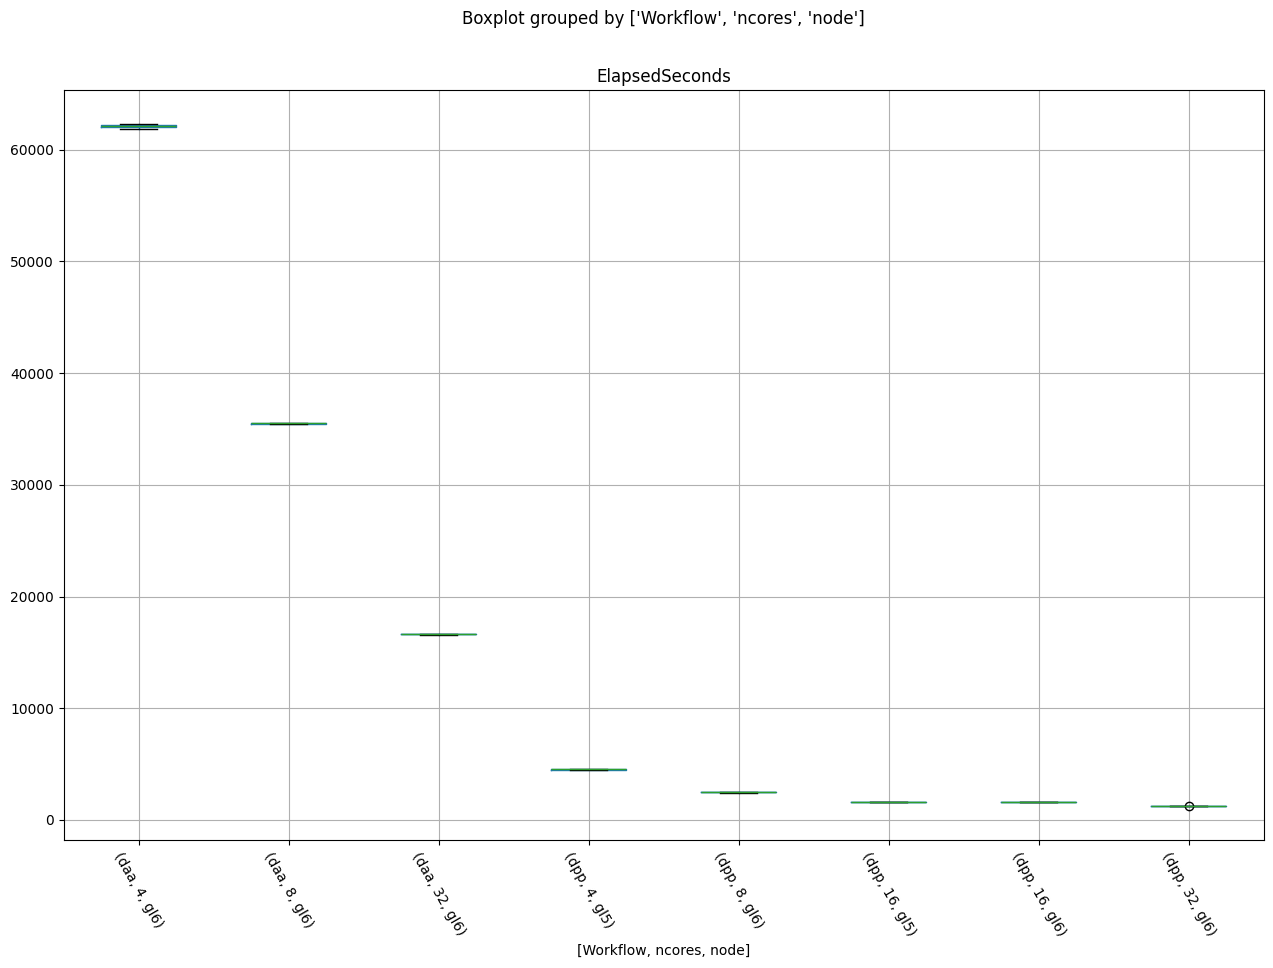

In [116]:
# draw one plot containing multiple boxplots with data distribution curve for each (workflow,ncores,node) agains EnergyConsumption
fig, ax = plt.subplots(figsize=(15, 10))
data_for_analysis.boxplot(column='ElapsedSeconds', by=['Workflow', 'ncores', 'node'], ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=-60)
# save
fig.savefig('new.boxplot.png')


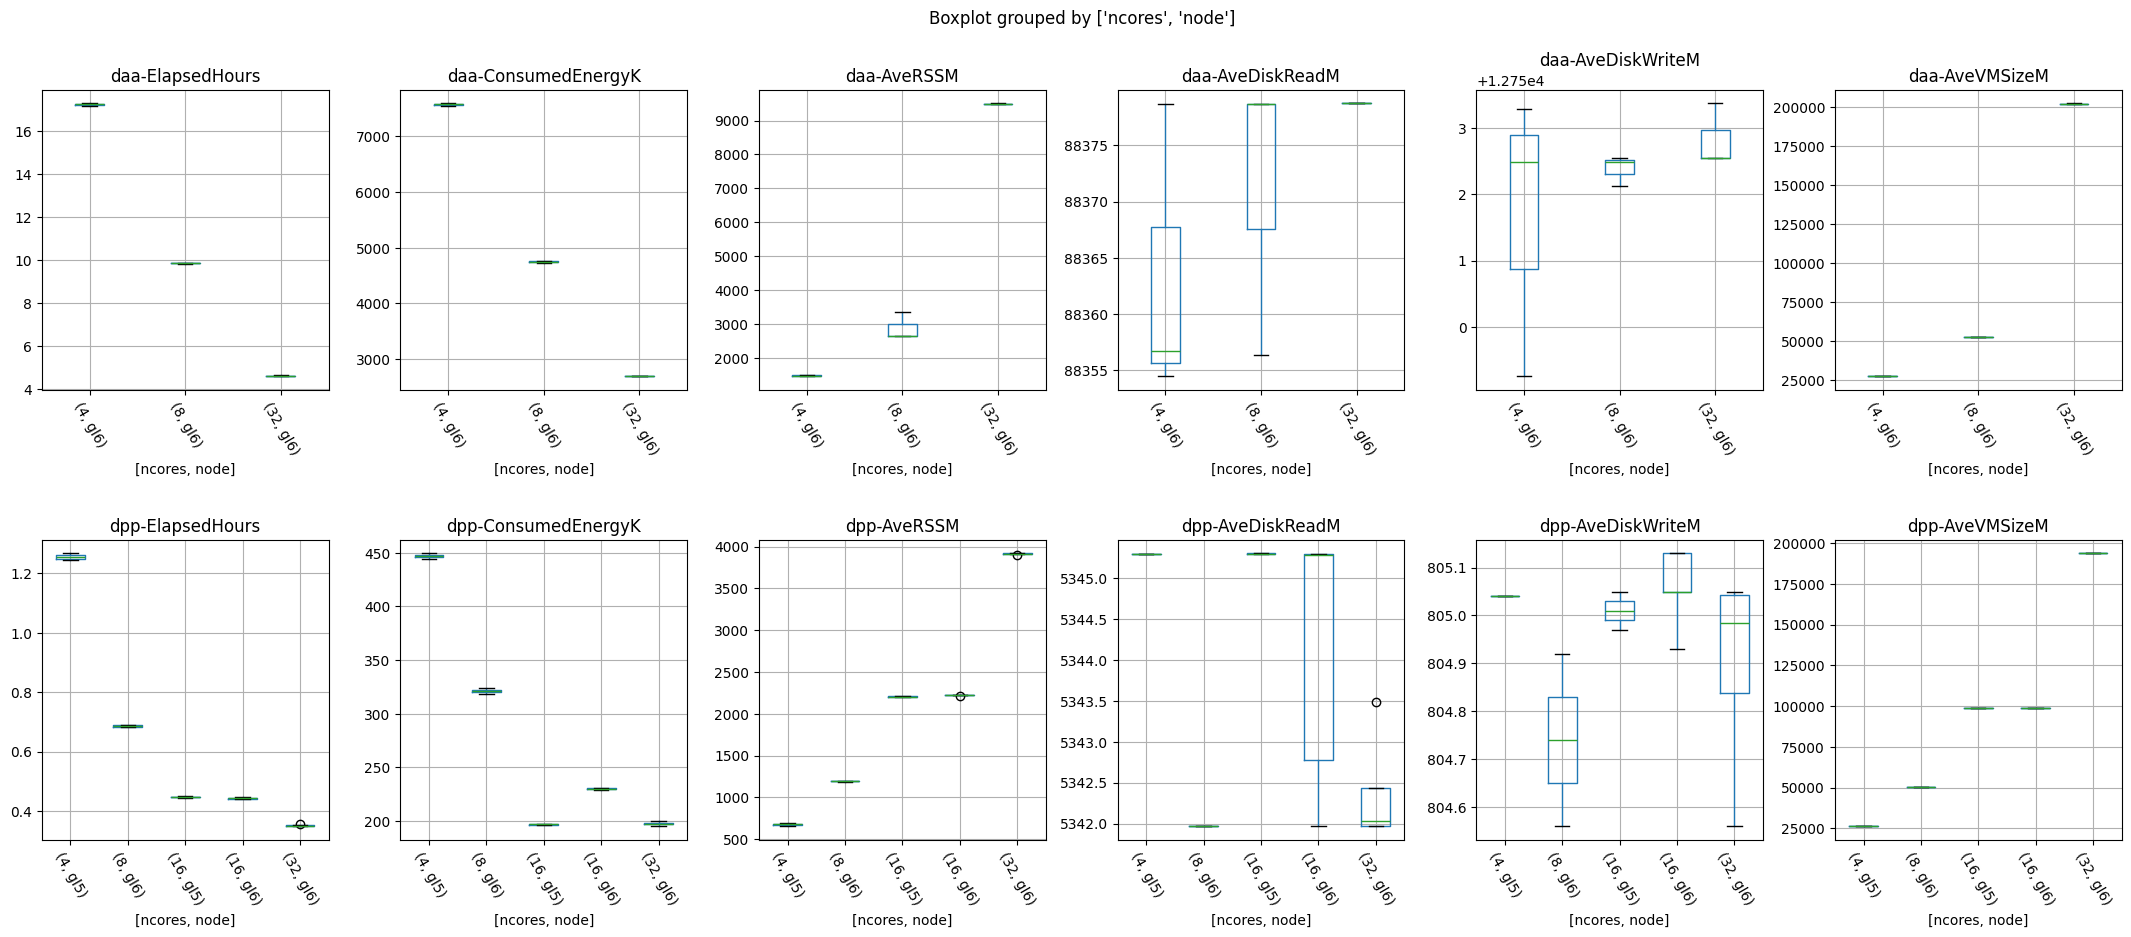

In [117]:
# draw two plots based on workflow containing multiple boxplots with data_for_analysis distribution curve for each (ncores,node) agains ConsumedEnergy, then 2 plots agains AveRSS, AveDiskRead, AveDiskWrite, AveVMSize. Add titles to plots with workflow name. Make sure that it is one big plot that contains all the subplots.
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(26, 10))
for j, workflow in enumerate(data_for_analysis.Workflow.unique()):
    for i, column in enumerate(
            ['ElapsedHours', 'ConsumedEnergyK', 'AveRSSM', 'AveDiskReadM', 'AveDiskWriteM', 'AveVMSizeM']):
        data_for_analysis[data_for_analysis.Workflow == workflow].boxplot(column=column, by=['ncores', 'node'],
                                                                          ax=ax[j, i])
        ax[j, i].set_title(f"{workflow}-{column}")
        ax[j, i].set_xticklabels(ax[j, i].get_xticklabels(), rotation=-60)
        # next to every boxplot box show data_for_analysis distribution

fig.subplots_adjust(hspace=0.5, wspace=0.25)

fig.savefig('new.boxplot-overview-by-workflows.png')

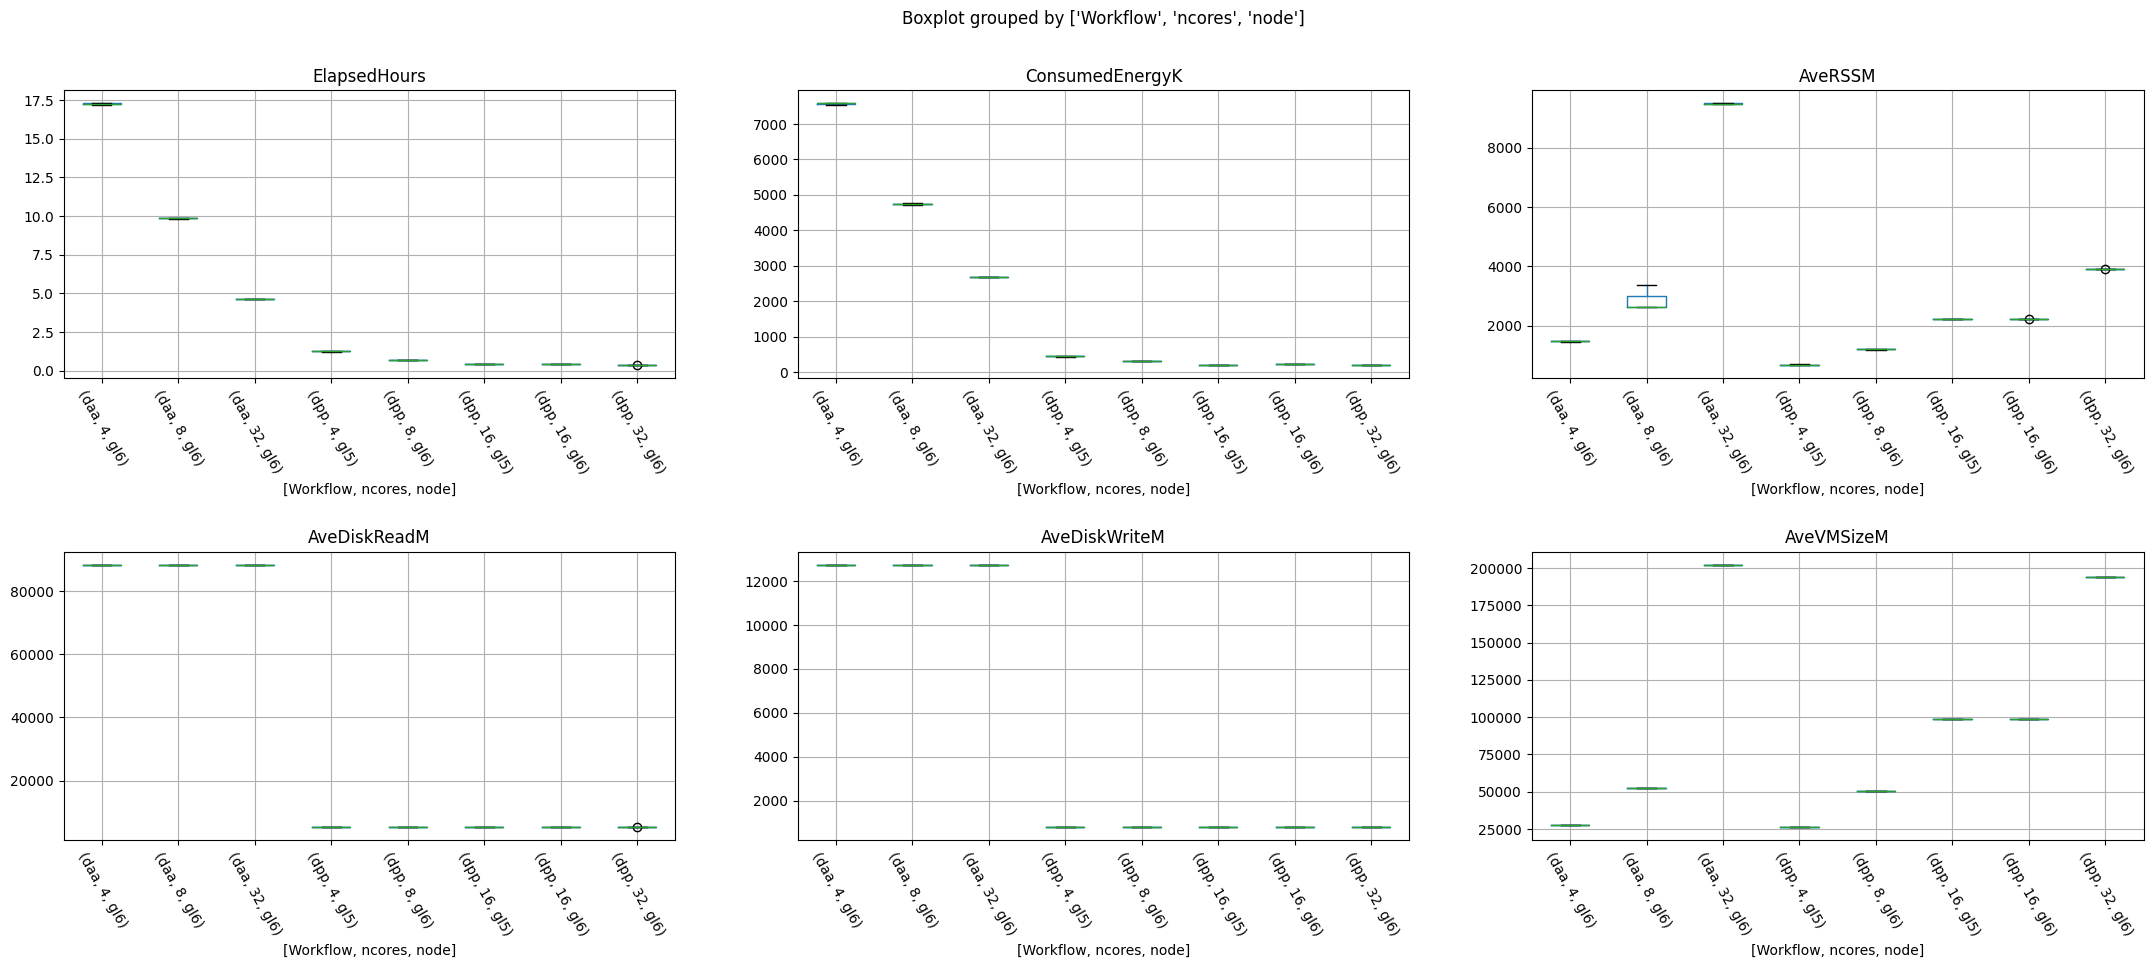

In [118]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(26, 10))
for i, column in enumerate(
        ['ElapsedHours', 'ConsumedEnergyK', 'AveRSSM', 'AveDiskReadM', 'AveDiskWriteM', 'AveVMSizeM']):
    data_for_analysis.boxplot(column=column, by=['Workflow', 'ncores', 'node'], ax=ax[i // 3, i % 3])
    ax[i // 3, i % 3].set_title(column)
    ax[i // 3, i % 3].set_xticklabels(ax[i // 3, i % 3].get_xticklabels(), rotation=-60)

fig.subplots_adjust(hspace=0.6)

fig.savefig('new.boxplot-overview.png')